<a href="https://colab.research.google.com/github/nirvan840/Improving-performance-using-GradCAM/blob/main/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving model performance using [GradCAM](https://youtu.be/eyKUqZOMfo0)
## Links (My Repo | Ref. Repo):
[<img src="https://pngimg.com/d/github_PNG58.png" alt="drawing" width="72"/>](https://github.com/nirvan840/Improving-performance-using-GradCAM)[<img src="https://icons.veryicon.com/png/o/miscellaneous/linear-small-icon/folder-329.png" alt="drawing" width="63"/>](https://github.com/JimEverest/CAM)

## Instructions:
* Using code cell bellow mount `Google Drive` to this notebook (please accept access permissions).
* Download and upload linked dataset ([.zip file](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)) to `My Drive` folder of **your** `Google Drive`.
  * In training data: 1341 normal and 3874 pneumonia | Normal is: 25.71%
  * In testing data: 234 normal and 390 pneumonia | Normal is: 37.50%
* Adjust parameters in "Hyper-parameters" section to decide on various features.
* Select .zip file name in "Hyper-parameters" section.


## Important:
* .zip file must be present in `drive/MyDrive/< .zip file name >`
* .zip file data extracted to `drive/MyDrive/ML Data Sets/< folder name >`
* Checkpointing of models saved to `drive/MyDrive/ML Models/< model name >`
* Train and Test history of models saved to `drive/MyDrive/ML Models/Train and Test Data/< model name >```


In [ ]:
# Mount Google Drive to Collab (please accept access permissions)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyper-parameters
* Set training hyper-parameters.
* Choose to toggle various features


In [ ]:
# .zip file name
ZIP_NAME    = "Pneumonia_DeepTek.zip"
FOLDER_NAME = "Pneumonia_DeepTek"   # .zip dataset extracted here

# Choose model architecture (availabe options: 'TinyVGG', 'VGG-16', 'ResNet-50', 'ResNet-101', 'ResNet-152')
MODEL_CHOICE = 'ResNet-101'

# Loading a Model and its Train and Test History
load_status = True                              # Load model from GDrive (drive/MyDrive/ML Models/<MODEL_NAME>) pre-training i.e. resuming progress
LOAD_NAME = f"{MODEL_CHOICE}_GradCAM_Crop_v3"   # MODEL_NAME to be loaded

# Saving a Model (state_dict only)
save_status = True                              # Save model to GDrive (drive/MyDrive/ML Models/<MODEL_NAME>) [ RECOMMENDED: True for Checkpointing ]
SAVE_NAME = f"{MODEL_CHOICE}_GradCAM_Crop_v3"   # MODEL_NAME to be saved

# Train Model
train_status = False

# Evaluate Model
evaluate_status = False     # Load and evaluate model on test data using various evaluation metrics (Section 3.6)
EVALUATE_NAME = SAVE_NAME   # MODEL_NAME to be evaluated

# Learning Rate | Epochs | Weight Decay
EPOCHS = 20
LR = 1e-4
WD = 1e-3
reset_LR = True            # If load_status = True and reset_LR = True, optimizer's loaded LR is overriden
reset_WD = True            # If load_status = True and reset_WD = True, optimizer's loaded Weight Decay is overriden

# Early Stopping Patience (Stop training if no improvement in test loss after specificed number of epochs)
PATIENCE = 5
early_stop_status = True    # Set to True to turn on Early Stopping

# Input Image will be resized and passed onto CNN | (256 for self-trained models in GitHub repo)
RESIZED_RESOLUTION = 224

In [ ]:
model_description = "1. Applied a Center Crop of 70% as model \n   was overfitting on void regions\n2. Increased FC Layer to 220k params\n3. Unfroze ResNet-101 layer4 + fc 6M params\n4. Weight decay on RAdam of 1e-5"

# Data preparation & analysis

## Setup and Data

### Dependancies

In [ ]:
# Import PyTorch
import torch
from torch import nn
!pip install torchinfo
from torchinfo import summary

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# VGG-16
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import vgg11, VGG11_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights
from torchvision.models import resnet101, ResNet101_Weights

# Data Loader
from torch.utils.data import DataLoader

# Mathplotlib
import matplotlib.pyplot as plt

# Pathlib
from pathlib import Path

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Version and Device
print(f"\nPyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Device: {device}")


PyTorch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121
Device: cuda


### Loading Data ( Pneumonia Chest X-ray )

#### Directory in Google Drive

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setting up Paths
data_path = Path("data/")
drive_path = Path("drive/MyDrive")
data_sets_path = drive_path / "ML Data Sets"
pneumonia_path = data_sets_path / FOLDER_NAME

# Checking if image folder exists in GDrive
if data_sets_path.is_dir():
  print(f"{data_sets_path}: directory exists.")
else:
  print(f"Did not find '{data_sets_path}' directory. Making directory in GDrive...")
  data_sets_path.mkdir(parents = True, exist_ok = True)

# Checking if Pneumonia Data Set is unzipped
if not (pneumonia_path).is_dir():
  # Unzipping
  with zipfile.ZipFile(drive_path / ZIP_NAME, "r") as zip_ref:
    print("Unzipping Pneumonia Data Set")
    zip_ref.extractall(data_sets_path)
    print("Done")
else:
  print(f"{pneumonia_path}: files exists. No unzipping.")

drive/MyDrive/ML Data Sets: directory exists.
drive/MyDrive/ML Data Sets/Pneumonia_DeepTek: files exists. No unzipping.


#### Directory Details

In [ ]:
import os
def walk_through_dir(dir_path, print_dir = False):
  """
  Walks through dir_path returning % of Normal Test, Train, Val Images
  If print_dir = True: Function returns all directories and files present in dir_path

  Args:
    dir_path (str or pathlib.Path): target directory
    print_dir (boolean, optional): Print directories and files in dir_path (default: False)

  Prints:
    % of Normal Test, Train, Val Images
    Optionally print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """

  # Printing directories
  if (print_dir):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"There are {dirnames} directories and {len(filenames)} images in '{dirpath}'.")
    print("")

  # Image counters
  train_normal = 0
  train_pneumonia = 0
  test_normal = 0
  test_pneumonia = 0
  val_normal = 0
  val_pneumonia = 0
  # Counting images
  for dirpath, dirnames, filenames in os.walk(dir_path):
    for filename in filenames:
      if "test" in dirpath:
        if "NORMAL" in dirpath:
          test_normal += 1
        else:
          test_pneumonia += 1
      #------------------------
      elif "train" in dirpath:
        if "NORMAL" in dirpath:
          train_normal += 1
        else:
          train_pneumonia += 1
      #------------------------
      elif "val" in dirpath:
        if "NORMAL" in dirpath:
          val_normal += 1
        else:
          val_pneumonia += 1
  # Printing number of images in each category
  print(f"In training data: {train_normal} normal and {train_pneumonia} pneumonia | Normal is: {train_normal/(train_normal+train_pneumonia)*100 :.2f}%")
  print(f"In testing data: {test_normal} normal and {test_pneumonia} pneumonia | Normal is: {test_normal/(test_normal+test_pneumonia)*100 :.2f}%")
  print(f"In validation data: {val_normal} normal and {val_pneumonia} pneumonia | Normal is: {val_normal/(val_normal+val_pneumonia)*100 :.2f}%")

In [ ]:
walk_through_dir(pneumonia_path)

In training data: 1341 normal and 3874 pneumonia | Normal is: 25.71%
In testing data: 234 normal and 390 pneumonia | Normal is: 37.50%
In validation data: 8 normal and 8 pneumonia | Normal is: 50.00%


#### Removing Corrupted Images

In [ ]:
file_path_corrupted = "drive/MyDrive/ML Data Sets/Pneumonia_DeepTek/train/PNEUMONIA/person1142_bacteria_3086.jpeg"
try:
  os.remove(file_path_corrupted)
  print(f"File '{file_path_corrupted}' deleted successfully.")

except FileNotFoundError: print(f"File '{file_path_corrupted}' not found.")

File 'drive/MyDrive/ML Data Sets/Pneumonia_DeepTek/train/PNEUMONIA/person1142_bacteria_3086.jpeg' not found.


#### Meta-Data and Data Transformations

In [ ]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.transforms import functional as F

# Random Image Choice
image_path_list = list(pneumonia_path.glob("*/*/*.jpeg"))
random_image = random.choice(image_path_list)
image_class = random_image.parent.stem
img = Image.open(random_image)

# Turn the image into an array
img_as_array = np.asarray(img)

In [ ]:
# Training Data Augmentation
crop_res = (int)(0.75*RESIZED_RESOLUTION)
print(crop_res)
data_transform = v2.Compose([
  v2.Grayscale(1),
  v2.RandomRotation(20),
  v2.RandomHorizontalFlip(p=0.5),
  v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  v2.RandomApply([transforms.RandomAffine(0, translate=(0.05, 0.3))], p=0.5),
  v2.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),
  v2.Resize(size=(RESIZED_RESOLUTION, RESIZED_RESOLUTION)),
  v2.CenterCrop(size=(crop_res, crop_res)),
  v2.Resize(size=(RESIZED_RESOLUTION, RESIZED_RESOLUTION)),
  v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485], std=[0.229]),
])

# Test Val Transform
data_transform_testval = v2.Compose([
  v2.Grayscale(1),
  v2.Resize(size=(RESIZED_RESOLUTION, RESIZED_RESOLUTION)),
  v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485], std=[0.229]),
])

# For untransformed train
data_transform_train_untf = v2.Compose([
  v2.Grayscale(1),
  v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
])

168


(-0.5, 223.5, 223.5, -0.5)

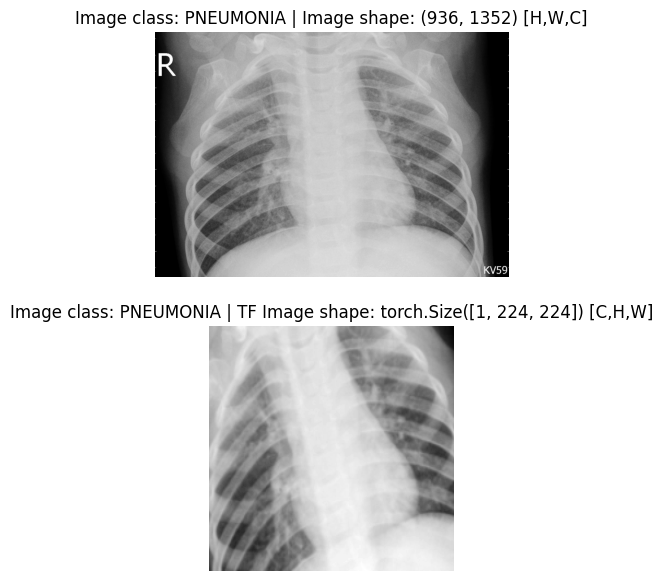

In [ ]:
# Applying transformations
transformed_image = data_transform(img)

s = 3
plt.figure(figsize=(21/s,21/s))
# Plot the original image
plt.subplot(2,1,1)
plt.imshow(img_as_array, cmap = "gray")
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} [H,W,C]")
plt.axis(False)

# Plot the transformed image
plt.subplot(2,1,2)
plt.title(f"Image class: {image_class} | TF Image shape: {transformed_image.shape} [C,H,W]")
plt.imshow(transformed_image.permute(1, 2, 0), cmap = "gray")
plt.axis(False)

### Train, Test & Val Data | Checking shape and label of data

* PyTorch generally accepts `[N,C,H,W]` (channels first) as the default shape for image tensors for many operators.

In [ ]:
train_data = datasets.ImageFolder(root = pneumonia_path / "train", transform = data_transform, target_transform = None)
train_data_testtransforms = datasets.ImageFolder(root = pneumonia_path / "train", transform = data_transform_testval, target_transform = None)
train_data_untransformed = datasets.ImageFolder(root = pneumonia_path / "train", transform = data_transform_train_untf, target_transform = None)
test_data = datasets.ImageFolder(root = pneumonia_path / "test", transform = data_transform_testval)
val_data = datasets.ImageFolder(root = pneumonia_path / "val", transform = data_transform_testval)

In [ ]:
image, label = train_data[random.randint(0, len(train_data)-1)]

# Data Shape
print(f"Train images: {len(train_data)}")
print(f"Test images: {len(test_data)}")
print(f"Val images: {len(val_data)}")

# Image label
print(f"\nImage tensor shape (C,H,W): {image.shape} | Label: {label}")

# Image length
#print(f"{len(train_data.data)}, {len(train_data.targets)}, {len(test_data.data)}, {len(test_data.targets)}")

# Class names
print(f"\nClass names: {train_data.class_to_idx}")

Train images: 5215
Test images: 624
Val images: 16

Image tensor shape (C,H,W): torch.Size([1, 224, 224]) | Label: 1

Class names: {'NORMAL': 0, 'PNEUMONIA': 1}


### Random Image from data

* In order to check effectiveness and resuslts of the transformations we applied

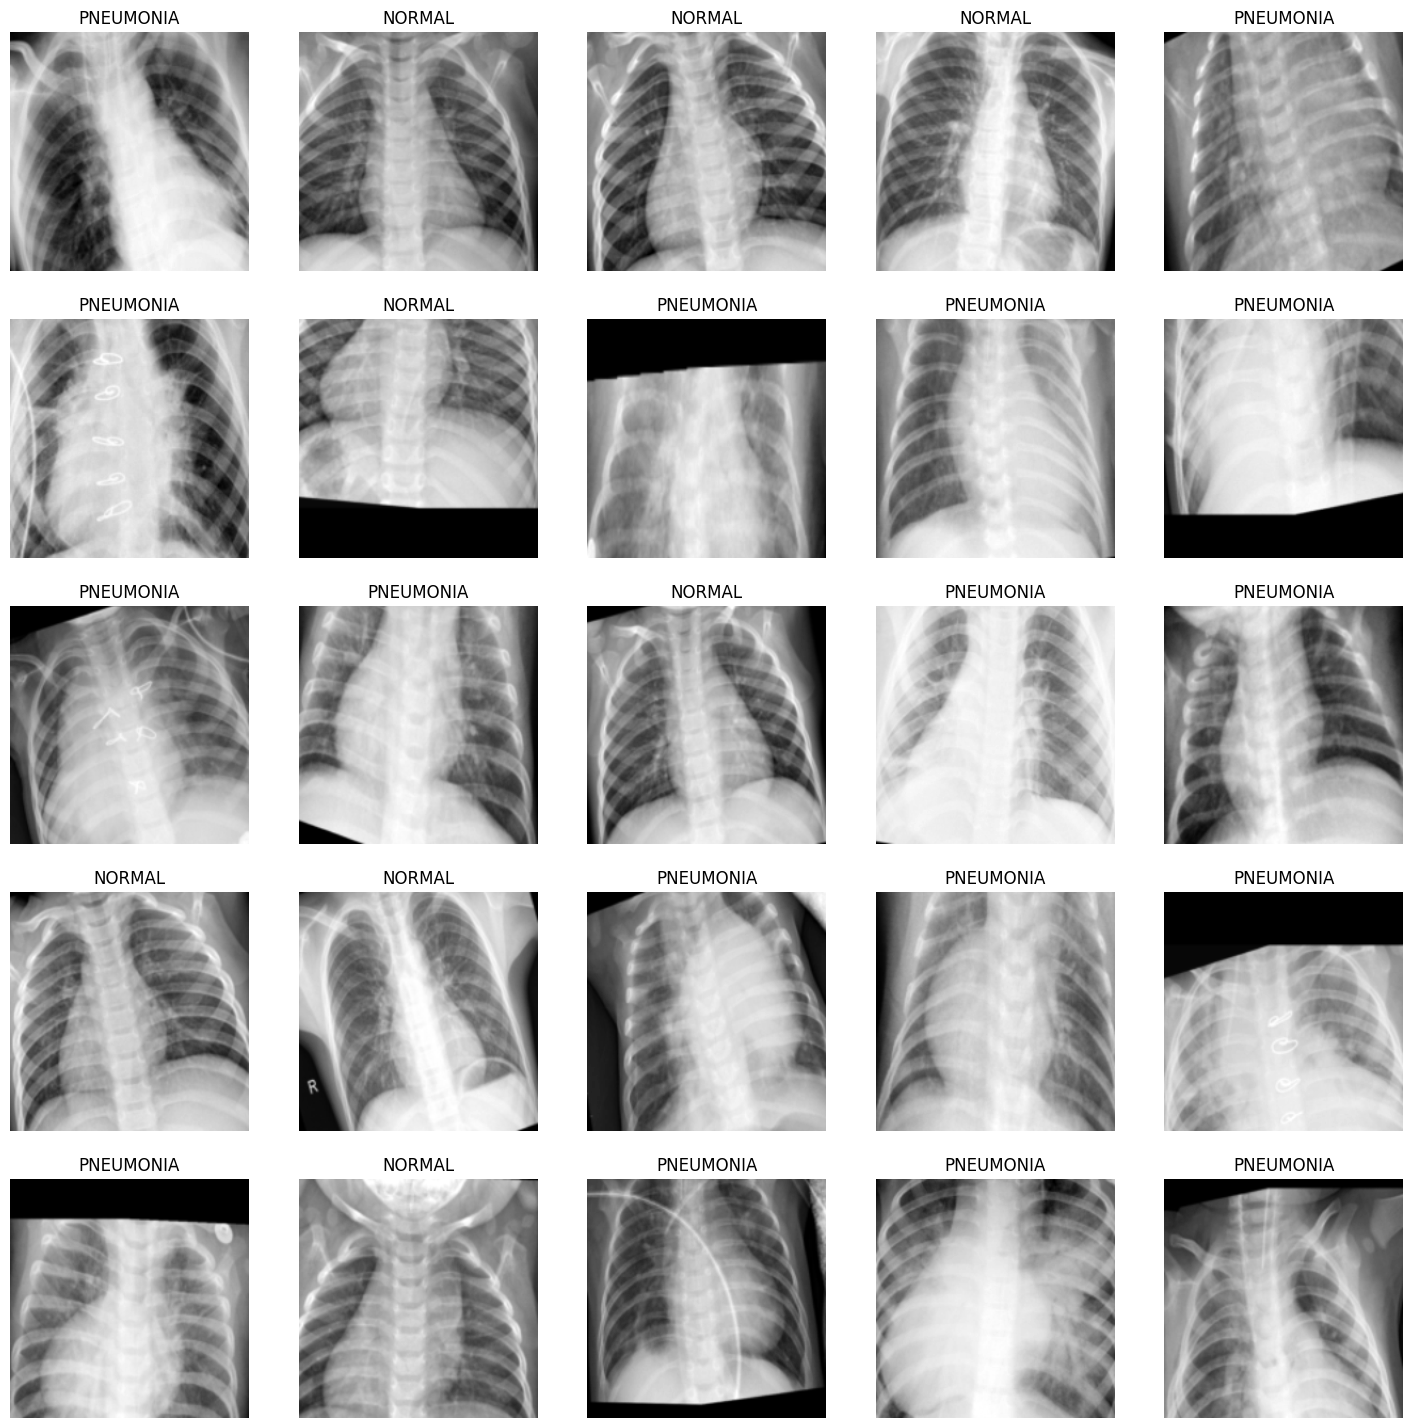

In [ ]:
#torch.manual_seed(42)
#random.seed(42)

fig = plt.figure(figsize = (18,18))
rows, cols = 5, 5

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0), cmap = "gray")
  plt.title(train_data.classes[label])
  plt.axis(False)

## Data Loader

In [ ]:
from torch.utils.data import DataLoader

# Batch size
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataLoader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataLoader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)
val_dataLoader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)

# Checking DataLoader
print(f"DataLoaders: {train_dataLoader, test_dataLoader}")
print(f"Length of train_dataLoader: {len(train_dataLoader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataLoader: {len(test_dataLoader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
print("")
train_features_batch, train_labels_batch = next(iter(train_dataLoader))
print(f"NCHW shape for Train Batch: {train_features_batch.shape} | Shape of Train Batch labels {train_labels_batch.shape}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x78ee07266ef0>, <torch.utils.data.dataloader.DataLoader object at 0x78ee07266650>)
Length of train_dataLoader: 163 batches of 32
Length of test_dataLoader: 20 batches of 32

NCHW shape for Train Batch: torch.Size([32, 1, 224, 224]) | Shape of Train Batch labels torch.Size([32])


#0. U-Net Lung Segmentation

## 0.1 Defining the Model

In [ ]:
class Block(torch.nn.Module):
  def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
    super().__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=3, padding=1)
    self.conv2 = torch.nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, padding=1)

    self.batch_norm = batch_norm
    if batch_norm:
      self.bn1 = torch.nn.BatchNorm2d(mid_channel)
      self.bn2 = torch.nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv1(x)
    if self.batch_norm:
        x = self.bn1(x)
    x = torch.nn.functional.relu(x, inplace=True)

    x = self.conv2(x)
    if self.batch_norm:
        x = self.bn2(x)
    out = torch.nn.functional.relu(x, inplace=True)
    return out

In [ ]:
class UNet(torch.nn.Module):
  def up(self, x, size):
    return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

  def down(self, x):
    return torch.nn.functional.max_pool2d(x, kernel_size=2)

  def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.batch_norm = batch_norm
    self.upscale_mode = upscale_mode

    self.enc1 = Block(in_channels, 64, 64, batch_norm)
    self.enc2 = Block(64, 128, 128, batch_norm)
    self.enc3 = Block(128, 256, 256, batch_norm)
    self.enc4 = Block(256, 512, 512, batch_norm)

    self.center = Block(512, 1024, 512, batch_norm)

    self.dec4 = Block(1024, 512, 256, batch_norm)
    self.dec3 = Block(512, 256, 128, batch_norm)
    self.dec2 = Block(256, 128, 64, batch_norm)
    self.dec1 = Block(128, 64, 64, batch_norm)

    self.out = torch.nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    enc1 = self.enc1(x)
    enc2 = self.enc2(self.down(enc1))
    enc3 = self.enc3(self.down(enc2))
    enc4 = self.enc4(self.down(enc3))

    center = self.center(self.down(enc4))

    dec4 = self.dec4(torch.cat([self.up(center, enc4.size()[-2:]), enc4], 1))
    dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
    dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
    dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))

    out = self.out(dec1)
    return out

In [ ]:
class PretrainedUNet(torch.nn.Module):
  def up(self, x, size):
    return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

  def down(self, x):
    return torch.nn.functional.max_pool2d(x, kernel_size=2)

  def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.batch_norm = batch_norm
    self.upscale_mode = upscale_mode

    self.init_conv = torch.nn.Conv2d(in_channels, 3, 1)

    endcoder = torchvision.models.vgg11(weights = VGG11_Weights.DEFAULT).features
    self.conv1  = endcoder[0]    # 64
    self.conv2  = endcoder[3]    # 128
    self.conv3  = endcoder[6]    # 256
    self.conv3s = endcoder[8]    # 256
    self.conv4  = endcoder[11]   # 512
    self.conv4s = endcoder[13]   # 512
    self.conv5  = endcoder[16]   # 512
    self.conv5s = endcoder[18]   # 512

    self.center = Block(512, 512, 256, batch_norm)

    self.dec5 = Block(512 + 256, 512, 256, batch_norm)
    self.dec4 = Block(512 + 256, 512, 128, batch_norm)
    self.dec3 = Block(256 + 128, 256, 64, batch_norm)
    self.dec2 = Block(128 + 64, 128, 32, batch_norm)
    self.dec1 = Block(64 + 32, 64, 32, batch_norm)

    self.out = torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    init_conv = torch.nn.functional.relu(self.init_conv(x), inplace=True)

    enc1 = torch.nn.functional.relu(self.conv1(init_conv), inplace=True)
    enc2 = torch.nn.functional.relu(self.conv2(self.down(enc1)), inplace=True)
    enc3 = torch.nn.functional.relu(self.conv3(self.down(enc2)), inplace=True)
    enc3 = torch.nn.functional.relu(self.conv3s(enc3), inplace=True)
    enc4 = torch.nn.functional.relu(self.conv4(self.down(enc3)), inplace=True)
    enc4 = torch.nn.functional.relu(self.conv4s(enc4), inplace=True)
    enc5 = torch.nn.functional.relu(self.conv5(self.down(enc4)), inplace=True)
    enc5 = torch.nn.functional.relu(self.conv5s(enc5), inplace=True)

    center = self.center(self.down(enc5))

    dec5 = self.dec5(torch.cat([self.up(center, enc5.size()[-2:]), enc5], 1))
    dec4 = self.dec4(torch.cat([self.up(dec5, enc4.size()[-2:]), enc4], 1))
    dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
    dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
    dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))

    out = self.out(dec1)

    return out

## 0.2 Initializing & Loading Model

In [ ]:
def load_UNet(MODEL_NAME, model):
  """
  - Loading U-Net Model from GitHub
  - Loads state_dict from .pt file present on GDrive
  """
  # Loading model state dict
  MODEL_PATH = Path("drive/MyDrive/ML Models")
  MODEL_NAME_pth = MODEL_NAME + ".pt"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_pth
  # Loading state_dict
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location = device))
  # Success
  print(f"{MODEL_NAME} loaded successfully")

In [ ]:
UNet1 = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
).to(device)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:24<00:00, 22.0MB/s]


In [ ]:
load_UNet("UNet_LungSegmentation", UNet1)
print(next(UNet1.parameters()).device)

UNet_LungSegmentation loaded successfully
cuda:0


## 0.3 Checking Masks

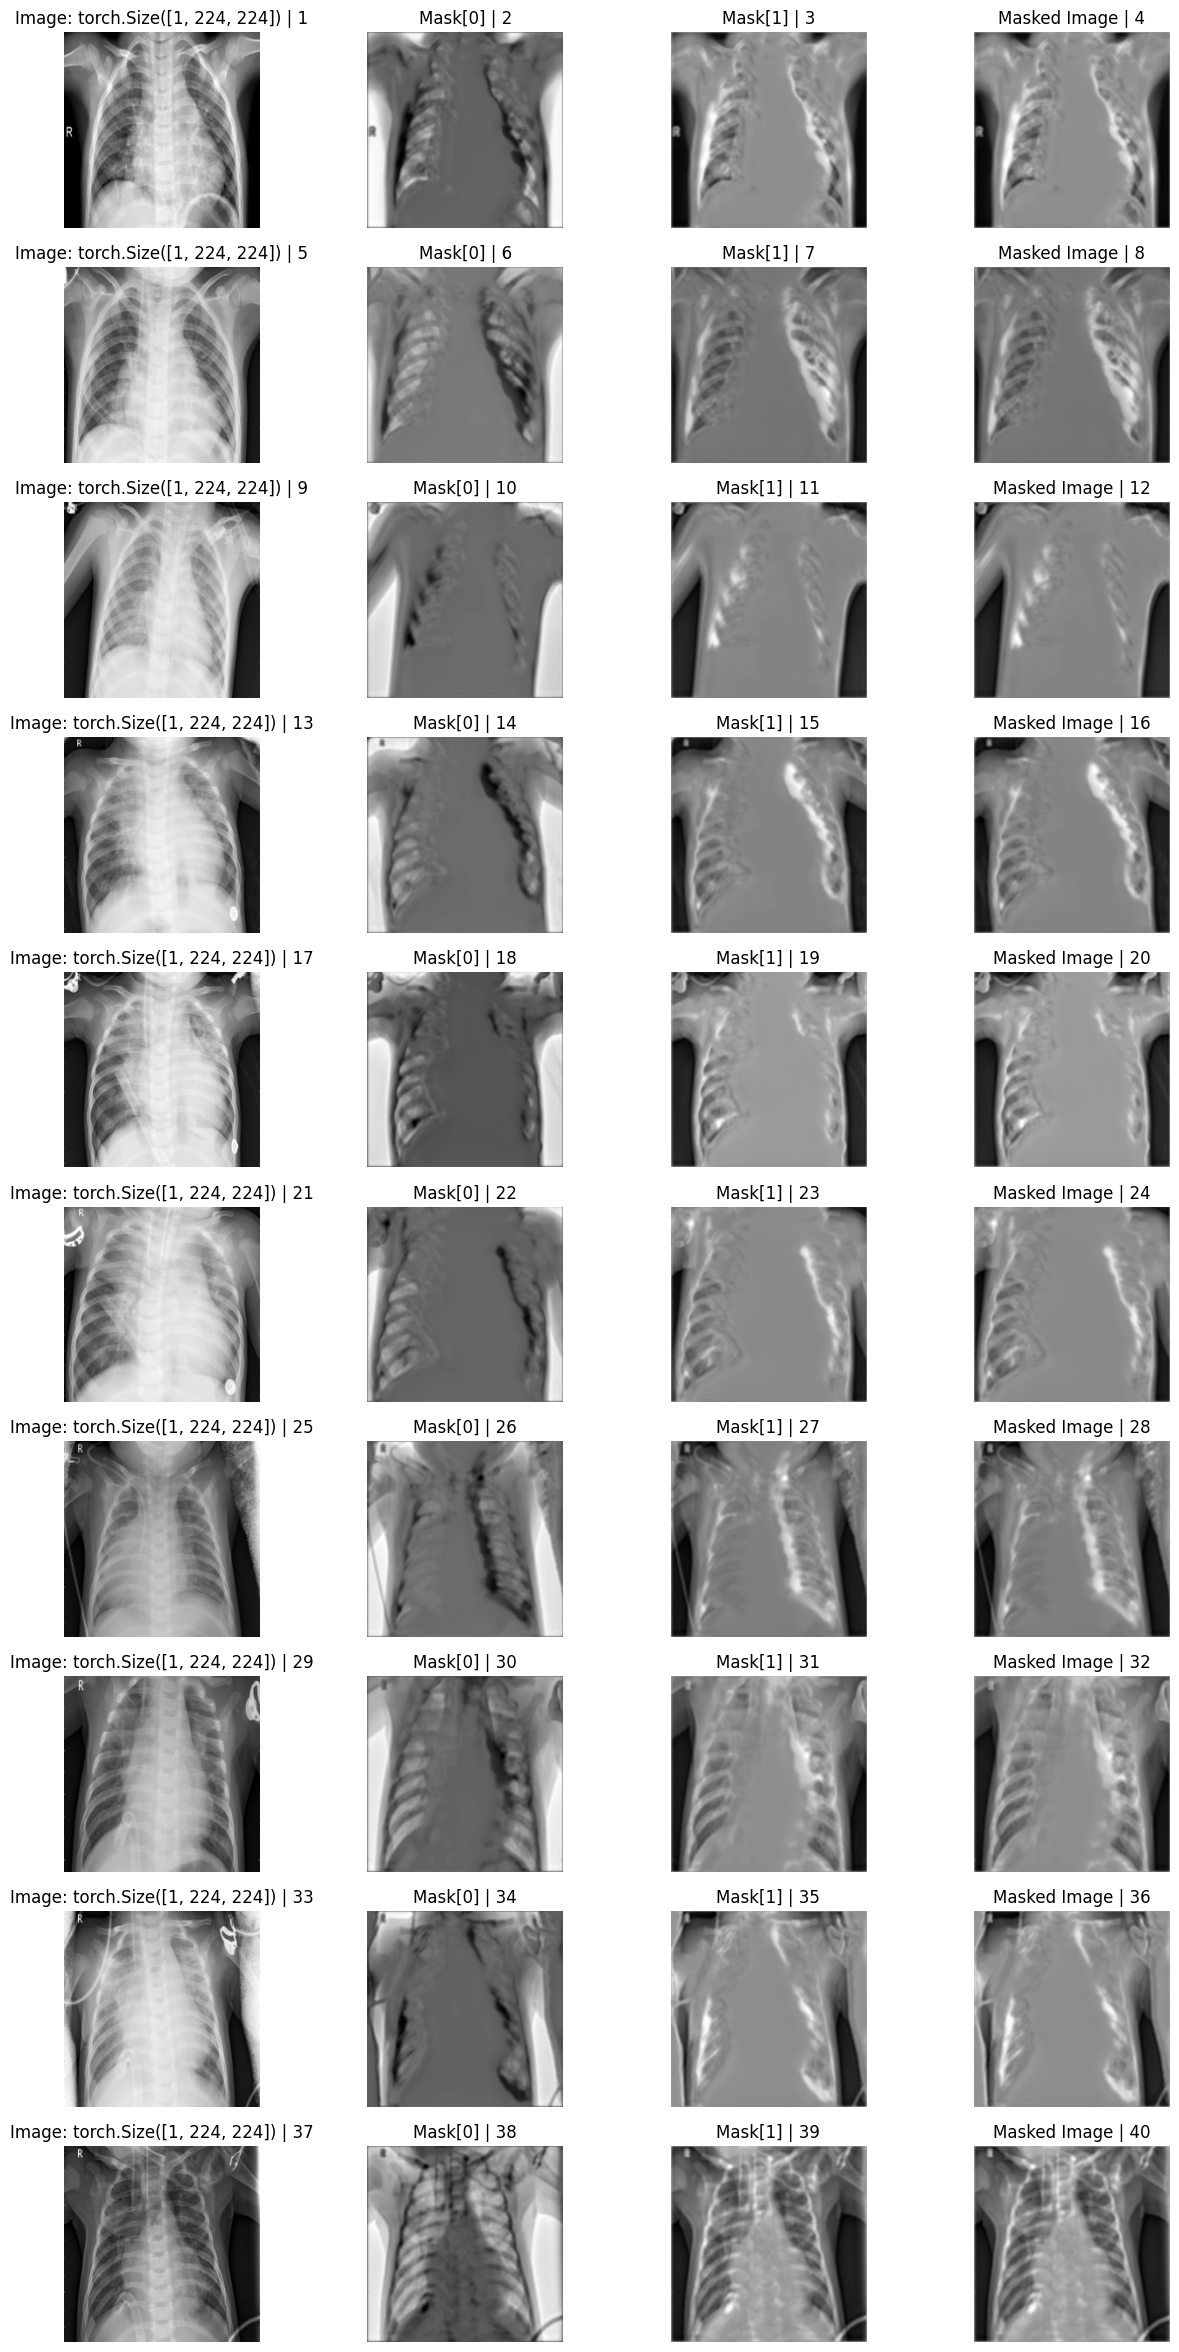

In [ ]:
# Plotting
scale = 2
fig = plt.figure(figsize = (15, 30))
row = 10
count = 0

UNet1.eval()
with torch.inference_mode():
  while count < row:
    # Getting Image and Mask
    # image, label = train_data_untransformed[random.randint(0, len(train_data)-1)]
    image, label  = test_data[-count-1]
    image = image.to(device)
    mask = UNet1(image.unsqueeze(0)).detach().squeeze(0)

    # Taking back to cpu for Matplotlib and OpenCV
    image = image.to("cpu")
    mask = mask.to("cpu")

    # Plotting
    fig.add_subplot(row,4,count*4+1)
    plt.imshow(image.permute(1,2,0), cmap = "gray")
    plt.title(f"Image: {image.shape} | {count*4+1}")
    plt.axis(False)

    fig.add_subplot(row,4,count*4+2)
    plt.imshow(mask[0], cmap = "gray")
    plt.title(f"Mask[0] | {count*4+2}")
    plt.axis(False)

    fig.add_subplot(row,4,count*4+3)
    plt.imshow(mask[1], cmap = "gray")
    plt.title(f"Mask[1] | {count*4+3}")
    plt.axis(False)

    fig.add_subplot(row,4,count*4+4)
    masked_image = image[0] + mask[1]*1e10
    masked_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min()) * 255
    plt.imshow(masked_image, cmap = "gray")
    plt.title(f"Masked Image | {count*4+4}")
    plt.axis(False)

    count += 1

  plt.show()

# 1. Defining CNN Models | Training the Model

## 1.1 Building CNN Model

### 1.3.1 Defining Architecture

#### TinyVGG

In [ ]:
class CNN(nn.Module):
  """
  CNN Model with 2 blocks
  Each block has:
    1. Conv2d
    2. ReLU
    3. MaxPool2d
  Fully connected Neural Network as the last layer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int, inp_res: int):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        # Block 1
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(0.25),
        # Block 2
        nn.Conv2d(hidden_units, hidden_units, 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, stride = 1, padding=1),
        nn.ReLU(),
    )
    self.gradients = None
    self.maxpool2d = nn.MaxPool2d(2)
    self.dense_neural_network = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.25),
        # Padding = 1 and CNN_kernel = 3 => no change in resolution | 2x MaxPool2d => resolution/4
        nn.Linear(hidden_units*(inp_res//4)*(inp_res//4), output_shape)
    )

  # Activation hook to capture intermediate gradients before they are discarded
  def activations_hook(self, grad):
    self.gradients = grad

  # Method for activation/feature extraction
  def get_activations(self, x):
    return self.feature_extractor(x)

  # Method for the gradient extraction
  def get_activation_gradients(self):
    return self.gradients

  # Forward pass
  def forward(self, x):
    x = self.feature_extractor(x)
    x.requires_grad_()
    # Register the hook at the feature map that we are interested in.
    h = x.register_hook(self.activations_hook)
    x = self.maxpool2d(x)
    x = self.dense_neural_network(x)
    return x

#### VGG-16

In [ ]:
class VGG(nn.Module):
  """
  VGG-16 Model
  Modified classifier layer to output 2 classes instead of 1000
  Model outputs logits
  """

  def __init__(self):
    super(VGG, self).__init__()
    # get the pretrained VGG19 network
    self.vgg = vgg16(weights = VGG16_Weights.DEFAULT)
    # disect the network to access its last convolutional layer
    self.feature_extractor = self.vgg.features[:30]
    # placeholder for the gradients
    self.gradients = None
    # get the max pool of the features stem
    self.max_pool = self.vgg.features[30]
    # Defining FC layer
    self.flatten = nn.Flatten()
    self.classifier = self.vgg.classifier
    self.dense_neural_network = nn.Sequential(
      nn.Linear(1000, 10),
      nn.ReLU(),
      nn.Dropout(0.20),
      nn.Linear(10, 2)
    )

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  # method for the gradient extraction
  def get_activation_gradients(self):
    return self.gradients

  # method for the activation exctraction
  def get_activations(self, x):
    return self.feature_extractor(x)

  def forward(self, x):
    x = self.feature_extractor(x)
    x.requires_grad_()
    # register the hook at the feature map that we are interested in.
    h = x.register_hook(self.activations_hook)
    # apply the remaining pooling
    x = self.max_pool(x)
    x = self.flatten(x)
    x = self.classifier(x)
    x = self.dense_neural_network(x)
    return x

#### RestNet-50


In [ ]:
class ResNet(nn.Module):

  def __init__(self):
    super(ResNet, self).__init__()
    # Get the pretrained VGG19 network
    self.resnet = resnet50(weights = ResNet50_Weights.DEFAULT)
    # Defining conv1 so it can be changed later on
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Defining FC layer
    self.dense_neural_network = nn.Sequential(
      nn.ReLU(),
      nn.Dropout(0.20),
      nn.Linear(1000, 10),
      nn.ReLU(),
      nn.Dropout(0.50),
      nn.Linear(10, 2)
    )

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  # method for the gradient extraction
  def get_activation_gradients(self):
    return self.gradients

  # method for the activation exctraction
  def get_activations(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    return x

  def forward(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    x.requires_grad_()
    # register the hook at the feature map that we are interested in.
    h = x.register_hook(self.activations_hook)
    # apply the remaining pooling
    x = self.resnet.avgpool(x)
    x = x.squeeze(dim = (2,3))
    # print("Shape of x after avg-pool: ", x.shape)
    x = self.resnet.fc(x)
    x = self.dense_neural_network(x)
    return x

In [ ]:
r = resnet50(weights = ResNet50_Weights.DEFAULT)
r.avgpool

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.8MB/s]


AdaptiveAvgPool2d(output_size=(1, 1))

#### ResNet-101


In [ ]:
class ResNet101(nn.Module):

  def __init__(self):
    super(ResNet101, self).__init__()
    # Get the pretrained VGG19 network
    self.resnet = resnet101(weights = ResNet101_Weights.DEFAULT)
    # Defining conv1 so it can be changed later on
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Defining FC layer
    self.dense_neural_network = nn.Sequential(
      nn.ReLU(),
      nn.Dropout(0.50),
      # FC1
      nn.Linear(1000, 200),
      nn.ReLU(),
      nn.Dropout(0.40),
      # FC2
      nn.Linear(200, 100),
      nn.ReLU(),
      nn.Dropout(0.20),
      # FC3
      nn.Linear(100, 2)
    )

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  # method for the gradient extraction
  def get_activation_gradients(self):
    return self.gradients

  # method for the activation exctraction
  def get_activations(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    return x

  def forward(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    x.requires_grad_()
    # register the hook at the feature map that we are interested in.
    h = x.register_hook(self.activations_hook)
    # apply the remaining pooling
    x = self.resnet.avgpool(x)
    x = x.squeeze(dim = (2,3))
    # print("Shape of x after avg-pool: ", x.shape)
    x = self.resnet.fc(x)
    x = self.dense_neural_network(x)
    return x

#### ResNet-152

In [ ]:
class ResNet152(nn.Module):

  def __init__(self):
    super(ResNet152, self).__init__()
    # Get the pretrained VGG19 network
    self.resnet = resnet152(weights = ResNet152_Weights.DEFAULT)
    # Defining conv1 so it can be changed later on
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Defining FC layer
    self.dense_neural_network = nn.Sequential(
      nn.ReLU(),
      nn.Dropout(0.50),
      nn.Linear(1000, 15),
      nn.ReLU(),
      nn.Dropout(0.50),
      nn.Linear(15, 2)
    )

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  # method for the gradient extraction
  def get_activation_gradients(self):
    return self.gradients

  # method for the activation exctraction
  def get_activations(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    return x

  def forward(self, x):
    x = self.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    x.requires_grad_()
    # register the hook at the feature map that we are interested in.
    h = x.register_hook(self.activations_hook)
    # apply the remaining pooling
    x = self.resnet.avgpool(x)
    x = x.squeeze(dim = (2,3))
    # print("Shape of x after avg-pool: ", x.shape)
    x = self.resnet.fc(x)
    x = self.dense_neural_network(x)
    return x

In [ ]:
r2 = resnet50(weights = ResNet50_Weights.DEFAULT)
r2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 1.3.2 Choosing a model architecture

In [ ]:
# Manual seed to "control" randomness of w and b when instantiating a new model
torch.manual_seed(32)

# Choosing architecture
model_1 = None
if MODEL_CHOICE == 'TinyVGG':
  model_1 = CNN(input_shape = 1, hidden_units = 15,
                output_shape = len(train_data.classes),
                inp_res = RESIZED_RESOLUTION).to(device)


elif MODEL_CHOICE == 'VGG-16':
  model_1 = VGG().to(device)
  # Changing input shape to have 1 channel
  original_conv1 = model_1.feature_extractor[0]
  model_1.feature_extractor[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
  # Here, we take the mean of the original weights across the 3 input channels to initialize the single channel
  with torch.inference_mode():
    model_1.feature_extractor[0].weight[:, 0, :, :] = original_conv1.weight.mean(dim=1)
    model_1.feature_extractor[0].bias = original_conv1.bias

  # Freezing layers except last 1000 -> 2 classifier
  for param in model_1.parameters(): param.requires_grad = False
  for param in model_1.dense_neural_network.parameters(): param.requires_grad = True


elif 'ResNet' in MODEL_CHOICE:
  if MODEL_CHOICE   == 'ResNet-50': model_1 = ResNet().to(device)
  elif MODEL_CHOICE == 'ResNet-101': model_1 = ResNet101().to(device)
  elif MODEL_CHOICE == 'ResNet-152': model_1 = ResNet152().to(device)
  # Changing input shape to have 1 channel
  original_conv1 = model_1.resnet.conv1
  # Here, we take the mean of the original weights across the 3 input channels to initialize the single channel
  with torch.inference_mode():
    model_1.conv1.weight[:, 0, :, :] = original_conv1.weight.mean(dim=1)

  # Freezing layers except last 1000 -> 2 classifier
  for param in model_1.parameters(): param.requires_grad = False
  for param in model_1.dense_neural_network.parameters(): param.requires_grad = True
  for param in model_1.resnet.layer4[2].parameters(): param.requires_grad = True
  for param in model_1.resnet.fc.parameters(): param.requires_grad = True

else:
  print("Invalid model choice")

# Summary of model
print(summary(model = model_1,
        input_size = (32, 1, RESIZED_RESOLUTION, RESIZED_RESOLUTION),
        col_names  = ["input_size", "output_size", "num_params", "trainable"],
        col_width  = 20,
        row_settings = ["var_names"]))

# Initializing test, train lists
train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list   = []

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 89.8MB/s]


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet101 (ResNet101)                         [32, 1, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                              [32, 1, 224, 224]    [32, 64, 112, 112]   (3,136)              False
├─ResNet (resnet)                             --                   --                   9,408                Partial
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 5

### 1.3.3 Checking Batch and Batch predictions shapes

In [ ]:
for batch, (X, y) in enumerate(train_dataLoader):
  # Send data to GPU
  X, y = X.to(device), y.to(device)
  y_preds = model_1(X)

  # Shapes
  print(f"Batch: {batch}: X shape: {X.shape} | y shape: {y.shape}")
  print(f"y_preds shape: {y_preds.shape} | max prob: {y_preds.argmax(dim=1).shape}")
  break

Batch: 0: X shape: torch.Size([32, 1, 224, 224]) | y shape: torch.Size([32])
y_preds shape: torch.Size([32, 2]) | max prob: torch.Size([32])


## 1.2 Functions to Load and Save | Callbacks

### 1.4.1 Load and Save Model


In [ ]:
def load_model(MODEL_NAME: str, model, optimizer = None, scheduler = None, load_lists = False):
  """
  Loads specified model saved in GDrive to model_1
  - Loads model state_dict
  - Loads optimizer state_dict
  - Loads test_loss, test_acc, epoch
  - Loads train, test lists
  """

  # Loading model state dict
  MODEL_PATH = Path("drive/MyDrive/ML Models")
  MODEL_NAME_pth = MODEL_NAME + ".pth"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_pth
  try:
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location = device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer != None: optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None: scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    test_loss = checkpoint['test_loss']
    test_acc  = checkpoint['test_acc']
    epoch     = checkpoint['epoch']
    desc      = checkpoint['desc']
    print(f"{MODEL_NAME} loaded successfully.")
  except OSError as e:
    print(f"OSError {e}\nDetails do not exist")

  # Loading Lists
  if load_lists:
    LISTS_SAVE_PATH = Path("drive/MyDrive/ML Models/Train Test Data/"+ MODEL_NAME)
    try:
      trl    = np.load(f"{LISTS_SAVE_PATH}/trl_{MODEL_NAME}.npy")
      tracc  = np.load(f"{LISTS_SAVE_PATH}/tracc_{MODEL_NAME}.npy")
      tstl   = np.load(f"{LISTS_SAVE_PATH}/tstl_{MODEL_NAME}.npy")
      tstacc = np.load(f"{LISTS_SAVE_PATH}/tstacc_{MODEL_NAME}.npy")
      print("Train and Test Lists loaded successfully.")
      return desc, test_loss, test_acc, epoch, list(trl), list(tracc), list(tstl), list(tstacc)
    except OSError as e:
      print(f"OSError {e}\nTrain, Test Lists do not exist")

  return test_loss, test_acc, epoch

In [ ]:
def save_model(MODEL_NAME: str, model, optimizer, scheduler, test_loss, test_acc, epoch, description = model_description) -> None:
  """
  Saves model_state_dict, optimizer_state_dict, test_loss, test_acc, epoch to GDrive
  Also saves model description (string) to GDrive
  Model saved as a .pth file
  """

  # Creating models directory
  MODEL_PATH = Path("drive/MyDrive/ML Models")
  if not MODEL_PATH.is_dir():
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    print(f"Made directory: {MODEL_PATH}")

  # Creating save path
  MODEL_NAME = MODEL_NAME + ".pth"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  # Saving model state_dict
  torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)
  torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'test_loss': test_loss,
            'test_acc': test_acc,
            'epoch': epoch,
            'desc': description},
             MODEL_SAVE_PATH)
  print(f"Model saved as {MODEL_NAME}")

In [ ]:
def save_list(MODEL_NAME: str, trl, tracc, tstl, tstacc):
  # Making a directory to save lists
  LISTS_SAVE_PATH = Path("drive/MyDrive/ML Models/Train Test Data/"+ MODEL_NAME)
  if not LISTS_SAVE_PATH.is_dir():
    LISTS_SAVE_PATH.mkdir(parents = True, exist_ok = True)
    print(f"Made directory: {LISTS_SAVE_PATH}")

  # Saving Lists
  np.save(f"{LISTS_SAVE_PATH}/trl_{MODEL_NAME}.npy", trl)
  np.save(f"{LISTS_SAVE_PATH}/tracc_{MODEL_NAME}.npy", tracc)
  np.save(f"{LISTS_SAVE_PATH}/tstl_{MODEL_NAME}.npy", tstl)
  np.save(f"{LISTS_SAVE_PATH}/tstacc_{MODEL_NAME}.npy", tstacc)
  print("Train and Test Lists saved successfully.")

### 1.4.2 Early Stopping and Checkpointing

* Creating a class -> Different objects of class can have different thresholds
* `__call__()` method called each time object of class is called with apt. params

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 5, min_delta = 0.0, restore_best_weights = True):
    self.patience  = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model  = None
    self.best_loss   = None
    self.best_epoch  = None
    self.counter = 0
    self.status  = ""

  def __call__(self, model, MODEL_NAME: str, save_status, save_list_fn, trl, trac, tstl, tstac,
               early_stop_status, optimizer, scheduler, test_loss, test_acc, epoch):
    # Fresh model training
    if self.best_loss == None:
      if save_status:
        save_model(MODEL_NAME, model, optimizer, scheduler, test_loss, test_acc, epoch)
        save_list_fn(SAVE_NAME, trl, trac, tstl, tstac)
      self.best_loss  = test_loss
      self.best_epoch = 1

    # Improvement more than min_delta
    elif (self.best_loss - test_loss) > self.min_delta:
      if save_status:
        save_model(MODEL_NAME, model, optimizer, scheduler, test_loss, test_acc, epoch)
        save_list_fn(SAVE_NAME, trl, trac, tstl, tstac)
      self.best_loss  = test_loss
      self.best_epoch = epoch+1
      self.status = f"Improvement found in epoch: {epoch+1} | After: {self.counter} epochs"
      print(self.status)
      self.counter = 0

    # No improvement
    else:
      self.counter += 1
      self.status = f"No improvement found in the last {self.counter} epochs"
      print(self.status)
      # Patience exceeded and early_stop_status = True
      if self.counter >= self.patience and early_stop_status:
        self.status = f"Early Stopping"
        print(self.status)
        if self.restore_best_weights and save_status:
          print("Restoring best model to model_1")
          load_model(MODEL_NAME, model, optimizer, scheduler)

Early1 = EarlyStopping(patience = PATIENCE, min_delta = 0.001)

## 1.3 Optimiser, Loss, Acc fn | Resume progress fn

### 1.5.1 Optimiser, Loss Function and custom Accuracy Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()
#optimizer  = torch.optim.SGD(model_1.parameters(), lr = LR, momentum = 0.9)                   # SGD lr ~0.1 | Momentum ~0.9
optimizer  = torch.optim.RAdam(params = model_1.parameters(), lr = LR, weight_decay = WD)      # Keep a LOW LR for RAdam and Adam 0.001 - 0.01
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 15, last_epoch=-1)  # Change last_epoch when using Adam for last 12 ephocs

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 1.5.2 Resuming progress function
* Accuracy and loss values should be similar to that of the model we loaded
* Accuracy on test set will be low if model_1 = random NEW model  

In [ ]:
def check_model(model):
  # Initialization
  test_loss, test_acc = 0, 0

  # Single batch to check acc
  model.eval()
  with torch.inference_mode():
    for (X, y) in tqdm(test_dataLoader):
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      # Forward Pass
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      # Batch loss and acc
      test_loss += loss
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

    # Output
    test_loss /= len(test_dataLoader)
    test_acc /= len(test_dataLoader)
    print(f"\nTest loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%")

    return test_loss, test_acc

## 1.4 Training and Testing Functions

### 1.6.1 Train Step

In [ ]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               train_loss_list, train_acc_list,
               device : torch.device = device):
  """
  Procedure that takes place in each epoch
  """

  # Initialization
  train_loss, train_acc = 0, 0
  model.to(device)

  # Batch Loop
  try:
    for batch, (X,y) in tqdm(enumerate(data_loader)):
      model.train()

      # Send data to GPU
      X = X.to(device)
      y = y.to(device)

      # Forward Pass
      y_pred = model(X)
      # Train Loss and Accuracy
      loss = loss_fn(y_pred, y)  # Output shape of CNN(y_pred): [m, 2] where m = batch size and 2 = NORMAL, PNEUMONIA
      train_loss += loss
      train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

      # Backpropagation and Gradient Descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print out how many samples have been seen
      if batch % 40 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataLoader.dataset)} samples")

  except OSError as e:
    print(f"OSError {e} in Batch, Skipping Batch")

  # Calculate loss and accuracy per epoch (Sum of train losses for all batches/no. of batches)
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  # Appending
  train_loss_list.append(train_loss.item())
  train_acc_list.append(train_acc)
  # Printing Results
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

### 1.6.2 Test Step

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              test_loss_list, test_acc_list,
              device: torch.device = device) -> float:

  # Initialization
  test_loss, test_acc = 0, 0
  model.to(device)

  # Testing
  model.eval()
  with torch.inference_mode():
    try:
      for batch, (X, y) in tqdm(enumerate(data_loader)):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        # Forward Pass
        test_pred = model(X)
        loss = loss_fn(test_pred, y)
        # Batch loss and acc
        test_loss += loss
        test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))
    except OSError as e:
      print(f"OSError {e} in Batch, Skipping Batch")

    # Per epoch
    test_loss /= len(data_loader)
    test_acc  /= len(data_loader)
    # Appending to list
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)
    # Printing Results
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

    # For Early Stopping
    return test_loss, test_acc

## 1.5 Training Essentials


### 1.5.1 Resuming Progress


In [ ]:
test_loss, test_acc = 0, 0

# Printing result ( Enter MODE_NAME without .pth extension )
if load_status:
  model_description, test_loss, test_acc, _, train_loss_list, train_acc_list, test_loss_list, test_acc_list = load_model(LOAD_NAME, model_1, optimizer, scheduler, load_lists = True);
  print(f"\nModel, optimizer, scheduler state_dicts loaded | Acc and Losses loaded | Epochs restored")
  print(f"Test loss: {test_loss:0.3f} | Test accuracy: {test_acc:0.2f}%")
  # Resetting LR
  if reset_LR: optimizer.param_groups[0]['lr'] = LR
  if reset_WD: optimizer.param_groups[0]['weight_decay'] = WD
else:
  test_loss, test_acc = check_model(model_1)

#print(f"Test acc list: {test_acc_list}")
initial_epochs = len(train_loss_list)
print(f"Epochs: {initial_epochs}")
print("\n-----------------------------------------------------------\n")

print(f"Model on device: {next(model_1.parameters()).device} \n")
print(model_description)
print("\n-----------------------------------------------------------")

print("\nOptimiser is:\n", optimizer)
print("\nScheduler is:\n", scheduler)
Early1.counter = 0
print("\nCounter is :", Early1.counter)
print("Patience is :", Early1.patience)

# Updating Checkpointing to resume progress
Early1.best_loss = test_loss

ResNet-101_GradCAM_Crop_v3 loaded successfully.
Train and Test Lists loaded successfully.

Model, optimizer, scheduler state_dicts loaded | Acc and Losses loaded | Epochs restored
Test loss: 0.325 | Test accuracy: 88.44%
Epochs: 22

-----------------------------------------------------------

Model on device: cuda:0 

1. Applied a Center Crop of 70% as model 
   was overfitting on void regions
2. Increased FC Layer to 220k params
3. Weight decay on RAdam of 1e-5
4. Unfroze ResNet-101 layer4 + fc 6M params

-----------------------------------------------------------

Optimiser is:
 RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.008
    lr: 0.0001
    weight_decay: 0.001
)

Scheduler is:

Counter is : 0
Patience is : 5


##### Misc

In [ ]:
# # Remove last n epoch from lists
# n = 1
# train_loss_list = train_loss_list[:-n]
# train_acc_list  = train_acc_list[:-n]
# test_loss_list  = test_loss_list[:-n]
# test_acc_list   = test_acc_list[:-n]
# save_list(SAVE_NAME, train_loss_list, train_acc_list, test_loss_list, test_acc_list)

In [ ]:
# optimizer.param_groups[0]['weight_decay'] = 1e-4
# save_model(SAVE_NAME, model_1, optimizer, scheduler, test_loss, test_acc, initial_epochs, model_description)

### 1.5.2 Training and Testing Engine
* To reset Early Stopping Patience, re-run Section 1.4 ***prior*** to traning
* After changing LR dont forget to re-run Section 1.5 ***prior*** to training
* Execute Resuming Progress ***after*** 1.4, 1.5


In [ ]:
if train_status:
  torch.manual_seed(42)

  # Measure time
  from timeit import default_timer as timer
  time_start = timer()

  # Train
  for epoch in tqdm(range(EPOCHS)):
    print(f"\nEPOCH: {epoch+initial_epochs+1}/{EPOCHS+initial_epochs}\n----------------------------")
    print("Training.......")
    model_1.train(True)
    train_step(model = model_1,
              data_loader = train_dataLoader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loss_list = train_loss_list,
              train_acc_list = train_acc_list,
              accuracy_fn = accuracy_fn)
    print("")
    print("Testing.......")
    test_loss, test_acc = test_step(data_loader = test_dataLoader,
                model = model_1,
                loss_fn = loss_fn,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                accuracy_fn = accuracy_fn)
    print("")
    # LR Scheduler
    scheduler.step()
    print(f"Current learning rate is {scheduler.get_last_lr()[0]: 0.5f}\n")

    # Early Stopping and Checkpointing Algorithm ( Enter model name without .pth extension )
    Early1(model_1, SAVE_NAME, save_status, save_list,
           train_loss_list, train_acc_list, test_loss_list, test_acc_list,
           early_stop_status, optimizer, scheduler, test_loss, test_acc, epoch)
    if Early1.status == "Early Stopping":
      print("")
      break
    print("\n")

  # ----------------------------------------------------------------------------

  # Lists
  print(f"Trained Epochs: {len(test_acc_list)}")
  if save_status: save_list(SAVE_NAME, train_loss_list, train_acc_list, test_loss_list, test_acc_list)

  # Measure time
  time_end = timer()
  print("\n------------------")
  print(f"Time taken on {device}: {(time_end - time_start)/60:.2f} minutes")

#### Learnings
* Do I really need LR Scheduling with RAdam/Adam?
* Train loss and acc staying almost constant -> Try increasing LR.
* Try LR of 0.007 or >> 0.001 for Adam to check on performance, before lowering it to the usual 0.001

# 2. GradCAM

## 2.1 Setup

In [ ]:
# Loading CNN Model
if load_status: load_model(LOAD_NAME, model_1)
check_model(model_1)

# Importing Libraries
import cv2
from google.colab.patches import cv2_imshow

# Testing
test_GradCAM = True

ResNet-101_GradCAM_Crop_v3 loaded successfully.


  0%|          | 0/20 [00:00<?, ?it/s]


Test loss: 0.325 | Test accuracy: 88.44%


## 2.2 Obtain GradCAM | Testing on images

### 2.2.1 Function to get GradCAM

In [ ]:
def get_GradCAM(model, input, pred, threshold = 0.80):
  model.eval()
  name = ''
  label_pred = 0
  status = "Bad"

  # Getting gradients wrt prediction class
  pred = torch.softmax(pred, dim = 1)

  # Gradients calc wrt chosen class
  if (pred[0][0] > pred[0][1]):
    pred[0][0].backward(retain_graph=True)
    name = 'NORMAL'
    label_pred = 0
  else:
    pred[0][1].backward(retain_graph=True)
    name = 'PNEUMONIA'
    label_pred = 1
  if (max(pred[0][0], pred[0][1]) >= threshold): status = "Good"

  # Getting activations of last layer
  activations = model.get_activations(input).detach()  # activations.shape = [N, (op_features of feature_extractor, H, W]
  # Getting gradients wrt activations
  gradients = model.get_activation_gradients()         # Have same shape as activations
  normalized_gradients = torch.mean(gradients, dim = [2, 3])  # [N,op_f,H,W] => here H and W dimensions are averaged out => pooled_gradients.shape = torch.Size([N, op_f])

  # Applying weights to activation maps
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= normalized_gradients[:, i].unsqueeze(1).unsqueeze(2)  # unsqz(1) and unsqz(2) to go from [N, op_f] -> [N,op_f,1,1] matches activations size. Required for accurate broadcasting
  # Combining all weighted activation maps and dividing by Z = no. of pixels
  heatmap = torch.mean(activations, dim = 1)
  heatmap = torch.relu(heatmap)
  heatmap /= torch.max(heatmap)                       # heatmap.shape = [N, H, W]

  return heatmap, name, label_pred, status

### 2.2.2 Function to Overlay GradCAM

In [ ]:
def overlayCAM(heatmap, input, overlap, display = True, resize = None, restrict_red = False, restrict_red_value = 120):
    """
    Goal:
      Superimposes heatmap on image
    Inputs:
      heatmap: tensor of shape [H, W]
      input: tensor of shape [C, H, W]
    Outputs:
      superimposed_img: tensor of shape [H, W, C]
    """

    # INPUT IMAGE
    img = input.permute(1, 2, 0).numpy()
    # Normalize image to range 0-255
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = np.uint8(img)
    # Convert RGB to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Resize the image
    if resize != None: img = cv2.resize(img, resize, interpolation=cv2.INTER_LANCZOS4)

    # GradCAM
    heatmap = heatmap.numpy()
    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Normalize heatmap to range 0-255
    heatmap = np.uint8(255*heatmap)
    # Apply color map to heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    if restrict_red:
      for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
          if heatmap[i][j][2] <= restrict_red_value:
            heatmap[i][j][0] = 0
            heatmap[i][j][1] = 0
            heatmap[i][j][2] = 0

    # OVERLAY
    superimposed_img = cv2.addWeighted(img, 1-overlap, heatmap, overlap, 0)

    # DISPLAY
    if display:
      print(f"Image shape: ",img.shape)
      cv2_imshow(img)
      print(f"GradCAM shape: ",heatmap.shape)
      cv2_imshow(heatmap)
      print(f"Superimposed shape: ", superimposed_img.shape)
      cv2_imshow(superimposed_img)

    return superimposed_img

### 2.2.3 Displaying GradCAM
* Executing the code produces GradCAMs for the test data set

In [ ]:
if test_GradCAM:

  # Creating Figure
  scale = 0.13
  fig = plt.figure(figsize = (15, 18))
  rows, cols = 8, 8

  count = 1
  while count <= (rows*cols):
    # Getting heatmap of images
    #img, label = test_data[random.randint(0, len(test_data)-1)]
    img, label = train_data_untransformed[-count-1]
    img = img.unsqueeze_(0).to(device)  # img.to(device) without '=' wont work | img.shape = [1,C,H,W]

    # Getting GradCAM
    model_1.eval()
    y_preds = model_1(img)              # y_preds.shape = [N, num_classes = 2]
    heatmap, name, label_pred, status = get_GradCAM(model_1, img, y_preds, threshold = 0.85)

    # Plotting prediction if correct
    if label_pred == label and status == "Good":
      # Plotting image
      img = img.squeeze(dim=0).to('cpu')
      # Plotting GradCAM
      GradCAM = heatmap[0].to('cpu')
      # Plotting Overlay
      superimposed_image = overlayCAM(GradCAM, img, display = False, overlap = 0.18, restrict_red = True, restrict_red_value = 150)
      fig.add_subplot(rows, cols, count)
      plt.imshow(superimposed_image)
      plt.title(f"{name} CLASS | {status}")
      plt.axis(False)
      # Image added to figure
      count = count + 1

    else: count += 1

  plt.show()

# 3. Evaluating Model

## 3.1 Setup

In [ ]:
# Importing and Downloading Libraries
!pip install -q torchmetrics
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
print(f"torch: {torch.__version__} | torchmetrics: {torchmetrics.__version__} | mlxtend: {mlxtend.__version__}\n")

# model_1 = restored as best performing CNN model
MODEL_NAME = EVALUATE_NAME  # Affects all MODEL_NAME variables below
if evaluate_status: _, _, _, _, train_loss_list, train_acc_list, test_loss_list, test_acc_list = load_model(MODEL_NAME, model_1, load_lists = True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 11.9 MB/s eta 0:00:00
torch: 2.3.1+cu121 | torchmetrics: 1.4.1 | mlxtend: 0.23.1



## 3.2 Function to calculate results

In [ ]:
def evaluate_model(model, MODEL_NAME, dataLoader, trl, trac, tstl, tstac, set_limit = False):
  """
  Calculates and prints: Test Loss, Test Acc | Confusion matrix, Sensitivity, Specificity | AUROC
  """

  # Getting all test predictions
  y_preds = []
  y_preds_pre_argmax = []
  model.eval()
  with torch.inference_mode():
    for (X, y) in (dataLoader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      y_preds_pre_argmax.append(y_pred)
      y_preds.append(y_pred.argmax(dim = 1).cpu())
  # Converting list to tensor ( y_preds has shape ([624]) = len(dataLoader) )
  y_preds_tensor = torch.cat(y_preds).cpu()
  y_preds_pre_argmax_tensor = torch.cat(y_preds_pre_argmax).cpu()
  # Converting test_data lables to tensor ( labels_tensor has shape ([624]) )
  labels_tensor = torch.tensor(test_data.targets).cpu()

  # Best epoch index = Least Test Loss
  idx = np.argmin(test_loss_list)

  # Accuracy
  print(f"For {MODEL_NAME}:\n")
  print(f"Test Loss: {test_loss_list[idx]:0.3f}\nTest Accuracy: {test_acc_list[idx]:0.2f}%")
  print("\n-------------------------------------------------------\n")

  # Loss and Accuracy curves
  print("Loss and Accuracy Curves:\n")
  plt.figure(figsize = (10,5))
  ax = plt.subplot(2,2,1)
  plt.plot(trl, label = "Train Loss", color = "red")
  plt.axvline(x=idx, color = 'gray', linestyle='--', linewidth=0.8)
  if set_limit: ax.set_ylim(0, 0.8)
  plt.legend()

  ax = plt.subplot(2,2,2)
  plt.plot(trac, label = "Train Accuracy")
  plt.axvline(x=idx, color = 'gray', linestyle='--', linewidth=0.8)
  if set_limit: ax.set_ylim(30, 100)
  plt.legend()

  ax = plt.subplot(2,2,3)
  plt.plot(tstl, label = "Test Loss", color = "red")
  plt.axvline(x=idx, color = 'gray', linestyle='--', linewidth=0.8)
  if set_limit: ax.set_ylim(0, 1.5)
  plt.legend()

  ax = plt.subplot(2,2,4)
  plt.plot(tstac, label = "Test Accuracy")
  plt.axvline(x=idx, color = 'gray', linestyle='--', linewidth=0.8)
  if set_limit: ax.set_ylim(30, 100)
  plt.legend()

  plt.show()
  print(f"\nBest epoch: {idx} (0 based counting)")
  print("\n-------------------------------------------------------\n")

  # Confusion matrix
  print("Confusion Matrix:\n")
  confmat = ConfusionMatrix(num_classes = len(train_data.classes), task = "multiclass") # Confmat Object
  confmat_tensor = confmat(preds = y_preds_tensor, target = labels_tensor) # Calling confmat method of object
  fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), show_absolute = True, show_normed = True, figsize = (3, 3)) # show_absolute, show_normed
  plt.title(train_data.class_to_idx)
  plt.show()
  # Sensitivity, Specificity, Recall, Precison (TP = Number of people who have the DISEASE and are CORRECTLY identified )
  specificity = torchmetrics.Specificity(task="binary")
  Spec = specificity(y_preds_tensor, labels_tensor).item()
  Sens = confmat_tensor[1,1] / (confmat_tensor[1,1] + confmat_tensor[1,0])
  print(f"\nSensitivity is: {Sens*100:0.2f}%\nSpecificity is: {Spec*100:0.2f}%")
  print("\n-------------------------------------------------------\n")

  # AUROC
  auroc_obj = torchmetrics.classification.MulticlassAUROC(num_classes = 2, average = None, thresholds = None)
  auroc = auroc_obj(y_preds_pre_argmax_tensor, labels_tensor)
  print(f"AUROC for NORMAL (Class 0): {auroc[0]:0.3f}")
  print(f"AUROC for PNEUMONIA (Class 1): {auroc[1]:0.3f}")

## 3.3 Printing Results

In [ ]:
if evaluate_status: evaluate_model(model_1,
                    MODEL_NAME,
                    test_dataLoader,
                    trl = train_loss_list,
                    trac = train_acc_list,
                    tstl = test_loss_list,
                    tstac = test_acc_list)